In [1]:
import os, glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.convert import concentration

import emiss_func, han_func, plot_info

In [2]:
year = 2014
months = [8, 12]
site = 'WAO'
species = 'o2'
resolution = {'day': 'daily', 'mth': 'monthly'}

ls = {'yr': '-', 'climatology': '--'}
colors = {'co2_nemo': 'darkorange', 'n2_nemo': 'forestgreen', 'o2_nemo': 'dodgerblue', 'o2_ecco': 'navy', 'o2_jena': 'purple'}

species = ['co2', 'n2', 'o2'] if species=='all' else [species]

time_diff = relativedelta(years=1, hours=-1) if months is None else relativedelta(months=1)
starts = datetime(year, 1, 1) if months is None else {month: datetime(year, month, 1) for month in months}
end = {month:start + time_diff for month, start in starts.items()}

In [3]:
clim_str = '-climatology' if year>2015 else ''
emissions_names = {res: {f'{spec}_nemo_{res}': f'{spec}{clim_str}-nemo-ocean-{res}'
                         for spec in species if not all([spec=='co2' and res=='day'])}
                   for res in resolution}
clim_str = '-climatology' if year>2018 else ''
emissions_names_o2 = {sim: {res: {f'o2_{sim}_{res}': f'o2{clim_str}-{sim}-ocean-{res}'}
                            for res in resolution if not all([sim=='jena' and res=='mth'])}
                      for sim in ['ecco', 'jena']}
emissions_names['mth'] = {**emissions_names['mth'], **emissions_names_o2['ecco']['mth']}
emissions_names['day'] = {**emissions_names['day'], **emissions_names_o2['ecco']['day'], **emissions_names_o2['jena']['day']}

# get the climatologies
if year<2018:
      emissions_clim_nemo = {res: {f'{spec}_nemo_{res}-climatology': f'{spec}-climatology-nemo-ocean-{res}'}
                                   for spec in species if not all([spec=='co2' and res=='day'])
                             for res in resolution}
      emissions_clim_o2 = {sim: {res: {f'o2_{sim}_{res}-climatology': f'o2-climatology-{sim}-ocean-{res}'}
                                 for res in resolution if not all([sim=='jena' and res=='mth'])}
                           for sim in ['ecco', 'jena']}

      emissions_names['mth'] = {**emissions_names['mth'], **emissions_clim_nemo['mth'], **emissions_clim_o2['ecco']['mth']}
      emissions_names['day'] = {**emissions_names['day'], **emissions_clim_nemo['day'], **emissions_clim_o2['ecco']['day'], **emissions_clim_o2['jena']['day']}

emissions_names = han_func.flatten_nested_dict(emissions_names, join_keys=False)
emissions_names

{'o2_nemo_day': 'o2-nemo-ocean-day',
 'o2_ecco_day': 'o2-ecco-ocean-day',
 'o2_jena_day': 'o2-jena-ocean-day',
 'o2_nemo_day-climatology': 'o2-climatology-nemo-ocean-day',
 'o2_ecco_day-climatology': 'o2-climatology-ecco-ocean-day',
 'o2_jena_day-climatology': 'o2-climatology-jena-ocean-day',
 'o2_nemo_mth': 'o2-nemo-ocean-mth',
 'o2_ecco_mth': 'o2-ecco-ocean-mth',
 'o2_nemo_mth-climatology': 'o2-climatology-nemo-ocean-mth',
 'o2_ecco_mth-climatology': 'o2-climatology-ecco-ocean-mth'}

In [4]:
emissions = {month: {spec: name.flux(domain = 'EUROPE', 
                                     species = em_spec, 
                                     start = start.strftime("%Y-%m-%d"), 
                                     end = end[month].strftime("%Y-%m-%d"))
                     for spec, em_spec in emissions_names.items()}
             for month, start in starts.items()}


Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/o2-nemo-ocean-day_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-nemo-ocean-day_EUROPE_2014.nc
Slicing time to range 2014-08-01 00:00:00 - 2014-08-31 23:59:59

Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/o2-ecco-ocean-day_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-ecco-ocean-day_EUROPE_2014.nc
Slicing time to range 2014-08-01 00:00:00 - 2014-08-31 23:59:59

Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/o2-jena-ocean-day_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-jena-ocean-day_EUROPE_2014.nc
Slicing time to range 2014-08-01 00:00:00 - 2014-08-31 23:59:59

Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/o2-climatology-nemo-ocean-day_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/o2-climat

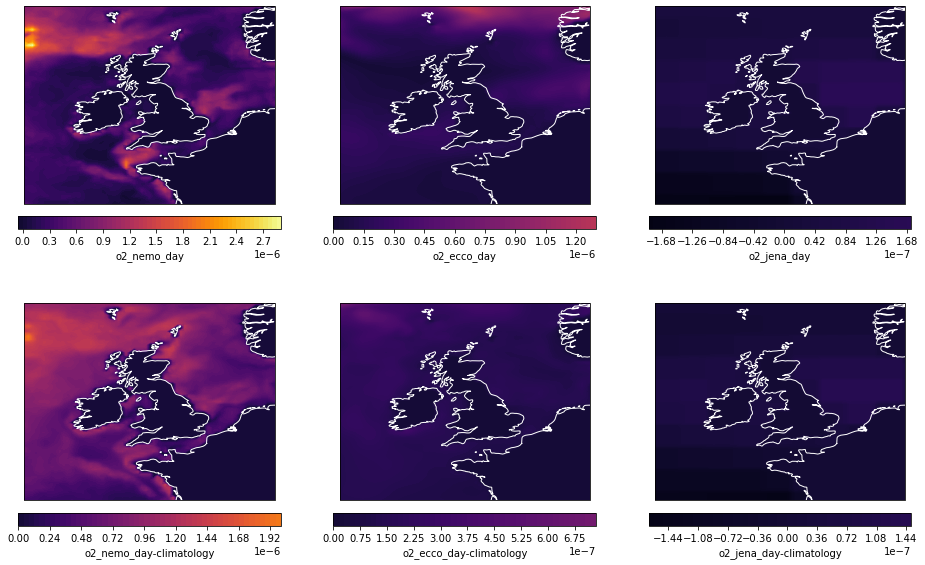

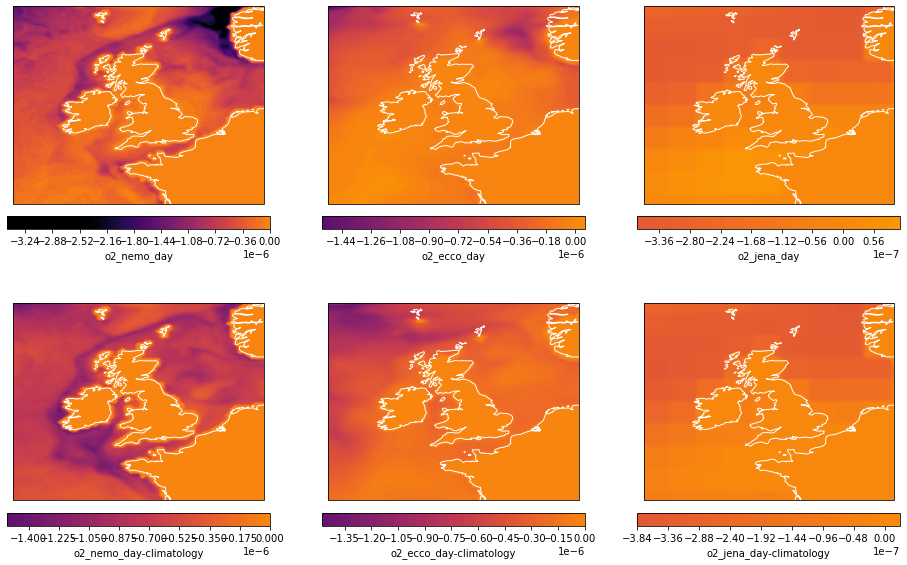

In [5]:
# data = {inv: emissions[inv].flux[:,:,0].fillna(0) for inv in ['o2_ecco_day', 'o2_ecco_mth', 'o2_nemo_day', 'o2_nemo_mth']}

data = {month: {inv: em_inv.flux[:,:,0].fillna(0) for inv, em_inv in emiss_month.items() if 'day' in inv}
        for month, emiss_month in emissions.items()}

for month, data_month in data.items():
    vmax = np.array([np.nanmax(dat.where(dat!=0)) for dat in data_month.values()]).max()
    vmin = np.array([np.nanpercentile(dat.where(dat!=0), 1) for dat in data_month.values()]).min()

    ax = han_func.show_map(data = list(data_month.values()),
                           fig_kwargs = {'nrows': 2, 'ncols': 3, 'figsize': (16,10)},
                           coast_color = 'white',
                           crop_uk = True,
                           im_kwargs = {'vmin': vmin, 'vmax': vmax},
                           colorbar_kwargs = {'label': list(data_month.keys())})

In [6]:
# dates to check: '2015-06-23'

month_check = 8
day_check = 7

date = f'{year}-{str(month).zfill(2)}-{str(day_check).zfill(2)}'
han_func.show_map(data = [emissions[month_check ]['o2_jena_day'].flux.sel(time=date),
                          emissions[month_check ]['o2_ecco_day'].flux.sel(time=date),
                          emissions[month_check ]['o2_nemo_day'].flux.sel(time=date)], crop_uk=True) 

KeyError: '2014-12-07'

In [7]:
fp_ds = {month: name.footprints(site, 'UKV',
                                start = start,
                                end = end[month],
                                species = None,
                                domain = 'EUROPE')
         for month, start in starts.items()}

No lifetime defined in species_info.json or species not defined. WARNING: 30-day integrated footprint used without chemical loss.
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_EUROPE_201408.nc
No lifetime defined in species_info.json or species not defined. WARNING: 30-day integrated footprint used without chemical loss.
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_EUROPE_201412.nc


In [8]:
mf_map = {month: {spec: em_spec.reindex_like(fp_ds[month].fp, method='ffill') * fp_ds[month].fp
                  for spec, em_spec in em_month.items()}
          for month, em_month in emissions.items()}
mf_ts = {month: {spec: mf.flux.sum(dim=['lat', 'lon']) / concentration('ppm')
                 for spec, mf in mf_month.items()}
         for month, mf_month in mf_map.items()}

In [9]:
mf_clim = {month: {res: {source: ts for source, ts in mf_month.items() if 'clim' in source and res in source}
                   for res in resolution}
           for month, mf_month in mf_ts.items()}
mf_yr = {month: {res: {source: ts for source, ts in mf_month.items() if 'clim' not in source and res in source}
                 for res in resolution}
         for month, mf_month in mf_ts.items()}

In [10]:
mf_all = {month: {flux_type: {res: {i: mf_res[i] for i in sorted(mf_res)}
                              for res, mf_res in mf.items()}
                  for flux_type, mf in {'yr': mf_month, 'climatology': mf_clim[month]}.items()}
         for month, mf_month in mf_yr.items()}

Saving to /user/work/vf20487/Figures/Timeseries/Ocean/WAO_O2_ocean_timeseries_201408-201412.png


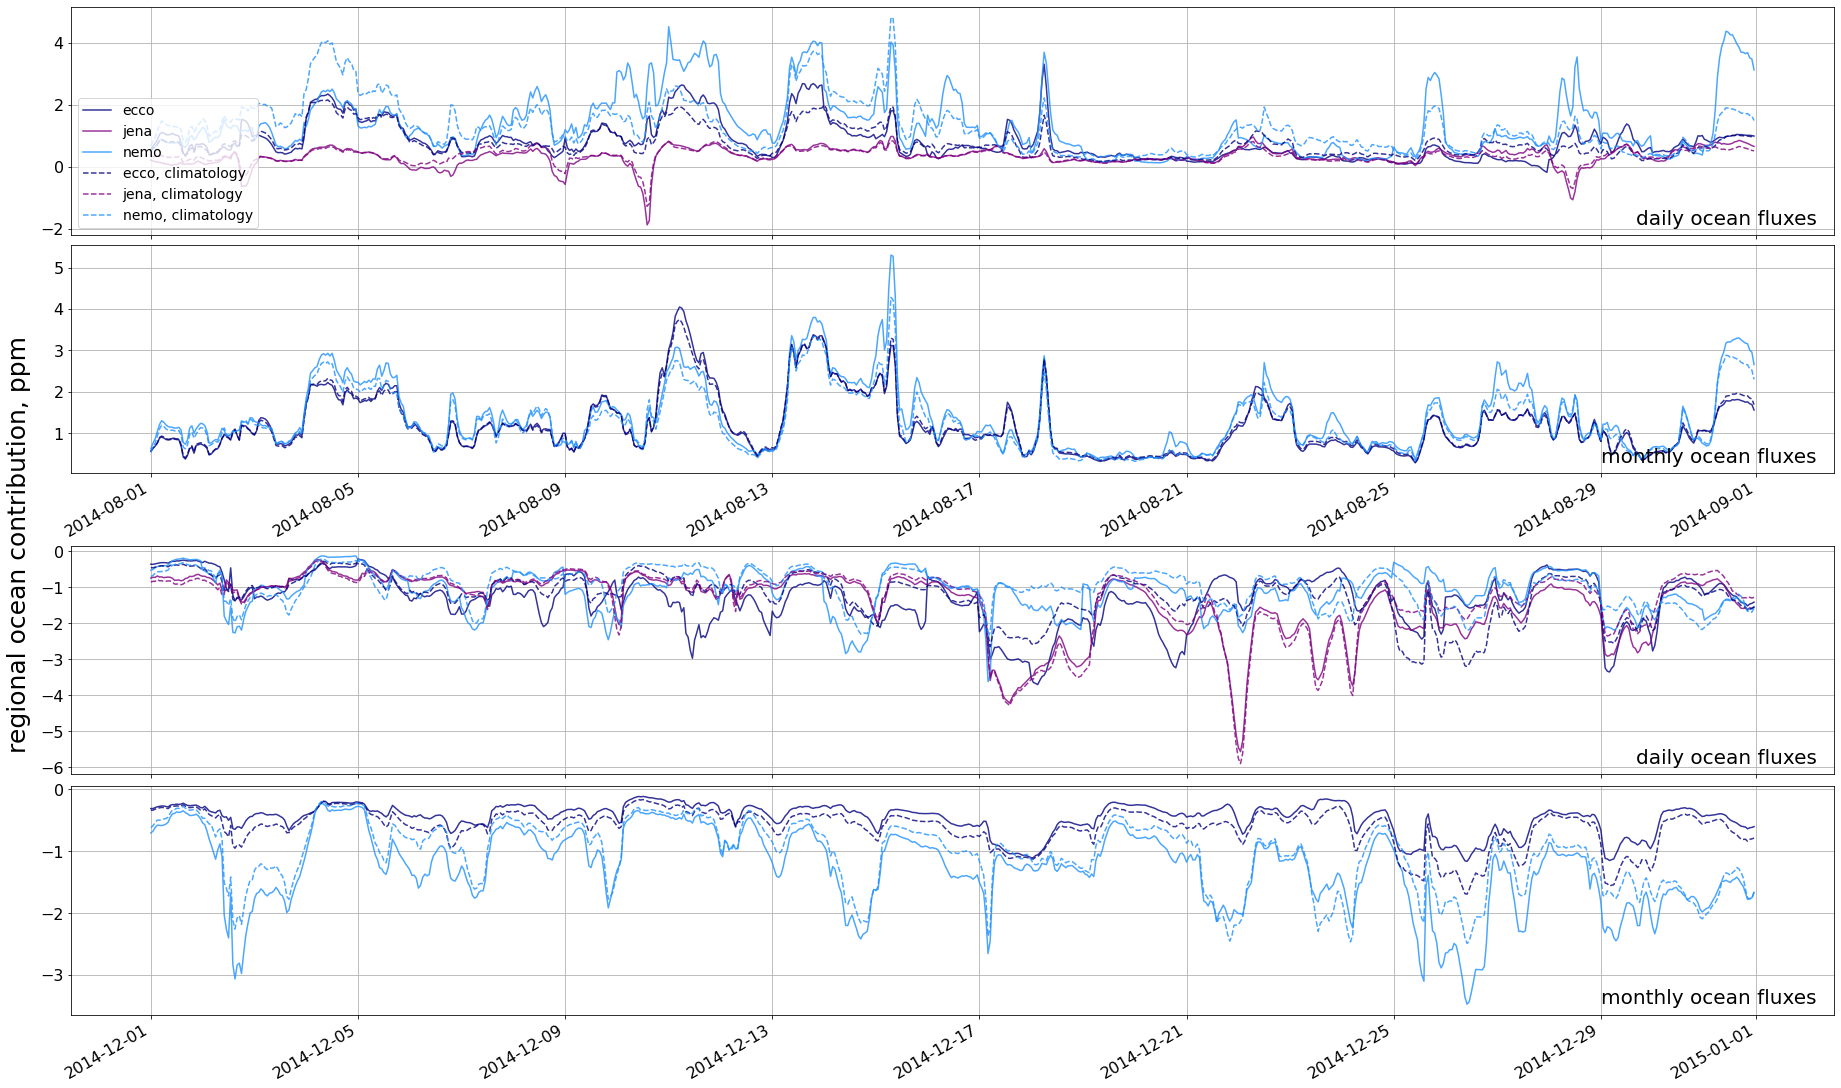

In [11]:
# labels = [{res: {spec: spec.split('_')[1] for spec in mf_res.keys()} for res, mf_res in mf_yr[months[0]].items()},
#           {res: {spec: f"{spec.split('_')[1]}, climatology" for spec in mf_res.keys()} for res, mf_res in mf_clim[months[0]].items()}]

fig, axes = plt.subplots(nrows=2*len(months), ncols=1, figsize=(25, 7.5*len(months)), constrained_layout=True)

for mm, (month, mf_month) in enumerate(mf_all.items()):
    for cc, (flux_type, mf) in enumerate(mf_month.items()):
        labels = {res: {spec: spec.split('_')[1] if flux_type=='yr' else f"{spec.split('_')[1]}, climatology" for spec in mf_res.keys()}
                for res, mf_res in mf.items()}
        plots = [[ts.plot(ax=axes[rr+2*mm], label=labels[res][spec], color=colors['_'.join(spec.split('_')[:2])], ls=ls[flux_type], alpha=0.8)
                for spec, ts in ts_res.items()] for rr, (res, ts_res) in enumerate(mf.items())]
            
legend = axes[0].legend(loc='lower left', fontsize=14)
xlab = [ax.set_xlabel('') for ax in axes]
ylab = [ax.set_ylabel('') for ax in axes]
grid = [ax.grid() for ax in axes]
ticks = [ax.tick_params(labelsize=16) for ax in axes]
[axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes))[0%2::2]]]
ylabel = fig.text(-0.01, 0.5, 'regional ocean contribution, ppm', va='center', ha='center', rotation='vertical', fontsize=25)
res_labels = [axes[rr].text(0.99, 0.03, f'{res} ocean fluxes', fontsize=20, va='bottom', ha='right', transform=axes[rr].transAxes)
              for rr, res in enumerate(list(resolution.values())*2)]

date_str = '-'.join([f'{year}{str(month).zfill(2)}'for month in months])
spec_str = 'all' if len(species)==3 else '-'.join(species)
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Ocean',
                        f'{site}_{spec_str.upper()}_ocean_timeseries_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

In [12]:
sources = ['ocean']
ts_data_all = {}

for d_type, clim_str in {'yr': '', 'climatology': '_climatology'}.items():
    print(f'{d_type} fluxes')
    ts_data_all[d_type] = {}
    for month, start in starts.items():
        print(f'Month: {month}')
        # paths to data
        ts_path = os.path.join('/user', 'work', 'vf20487', 'Timeseries', 'o2_co2')

        # find the file
        ts_files = {source: glob.glob(os.path.join(ts_path, f'{site}_{source}*timeseries{clim_str}_{year}.nc'))
                    for source in sources}
        if 'ff' in sources:
            ts_files['ff'] = [ff for ff in ts_files['ff'] if 'ff_time' in ff]

        [print(f'{source}: {file_source}') for source, file_source in ts_files.items()]

        ts_data_dict = {source: name.open_ds(file_source[0]) for source, file_source in ts_files.items()
                        if len(file_source)>0}

        ts_data = ts_data_dict['ff']['co2'].to_dataset(name='co2_ff') if 'ff' in ts_data_dict.keys() else \
                ts_data_dict['ocean']['co2_nemo_mth'].to_dataset(name='co2_ocean_nemo_mth')
        for source, ts_data_source in ts_data_dict.items():
            for data_var in ts_data_source.data_vars:
                dv_name = f'{data_var.split("_")[0]}_ocean_{"_".join(data_var.split("_")[1:])}' if source=='ocean' \
                        else f'{data_var}_{source}'
                var_name = f'co2_{dv_name}' if not any([spec in dv_name for spec in ['co2', 'n2', 'o2', 'apo']]) else dv_name
                ts_data[var_name] = ts_data_source[data_var]

        ts_data = ts_data.sel(time=slice(start, end[month]))

        # # make sur the units are correct
        for vv in ts_data.data_vars:
            ts_data[vv] = ts_data[vv] / concentration('ppm') if all(abs(ts_data[vv])<1e-4) else ts_data[vv]
            if '-' in vv:
                print(f"renaming {vv}: {'_'.join(vv.split('-'))}")
                ts_data = ts_data.rename({vv: '_'.join(vv.split('-'))})

        vars_drop = [dv for dv in ts_data.data_vars if any([ss in dv for ss in ['unc', 'diff']])]
        vars_drop2 = [dv for dv in ts_data.data_vars if dv not in vars_drop and all([dv.split('_')[0]!=spec for spec in ['apo', 'co2', 'n2', 'o2']])]
        ts_data = ts_data.drop_vars(vars_drop)
        ts_data = ts_data.drop_vars(vars_drop2)

        ts_data_all[d_type][month] = ts_data

        print('\nData variables:')
        print([dv for dv in ts_data.data_vars])

yr fluxes
Month: 8
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2014.nc']

Data variables:
['co2_ocean_nemo_mth', 'o2_ocean_nemo_day', 'n2_ocean_nemo_day', 'o2_ocean_ecco_day', 'o2_ocean_jena_day', 'o2_ocean_nemo_mth', 'n2_ocean_nemo_mth', 'o2_ocean_ecco_mth']
Month: 12
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2014.nc']

Data variables:
['co2_ocean_nemo_mth', 'o2_ocean_nemo_day', 'n2_ocean_nemo_day', 'o2_ocean_ecco_day', 'o2_ocean_jena_day', 'o2_ocean_nemo_mth', 'n2_ocean_nemo_mth', 'o2_ocean_ecco_mth']
climatology fluxes
Month: 8
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_climatology_2014.nc']

Data variables:
['co2_ocean_nemo_mth', 'o2_ocean_nemo_day', 'n2_ocean_nemo_day', 'o2_ocean_ecco_day', 'o2_ocean_jena_day', 'o2_ocean_nemo_mth', 'n2_ocean_nemo_mth', 'o2_ocean_ecco_mth']
Month: 12
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_climatology_2014.nc']

Data variables:
['co2_ocean_nemo_mth', 

In [13]:
apo_species = {d_type: {month: {res: emiss_func.apo_species_split(ocean_co2 = ts_month.co2_ocean_nemo_mth,
                                                                  ocean_n2 = ts_month.n2_ocean_nemo_day,
                                                                  ocean_o2 = ts_month[f'o2_ocean_ecco_{res}'])
                                for res in ['day', 'mth']}
                        for month, ts_month in ts_type.items()}
               for d_type, ts_type in ts_data_all.items()}

for d_type, ts_type in ts_data_all.items():
    for month, ts_month in ts_type.items():
        for res in ['day', 'mth']:
            apo_species[d_type][month][res] = {'o2_ocean_ecco' if k == 'o2_ocean' else k:v for k,v in apo_species[d_type][month][res].items()}
            for sim in ['jena', 'nemo']:
                if f'o2_ocean_{sim}_{res}' in ts_month.data_vars:
                    apo_species[d_type][month][res][f'o2_ocean_{sim}'] = emiss_func.apo_species_split(ocean_o2 = ts_month[f'o2_ocean_{sim}_{res}'])['o2_ocean']

apo_split = {d_type: {month: {res: {ocean_sim.split("_")[-1]: apo_res['co2_ocean'] + apo_o2 + apo_res['n2_ocean']
                                    for ocean_sim, apo_o2 in apo_res.items() if ocean_sim[:8]=='o2_ocean'}
                              for res, apo_res in apo_month.items()}
                    for month, apo_month in apo_type.items()}
             for d_type, apo_type in apo_species.items()}

Saving to /user/work/vf20487/Figures/Timeseries/Ocean/WAO_APO_ocean_timeseries_201408-201412.png


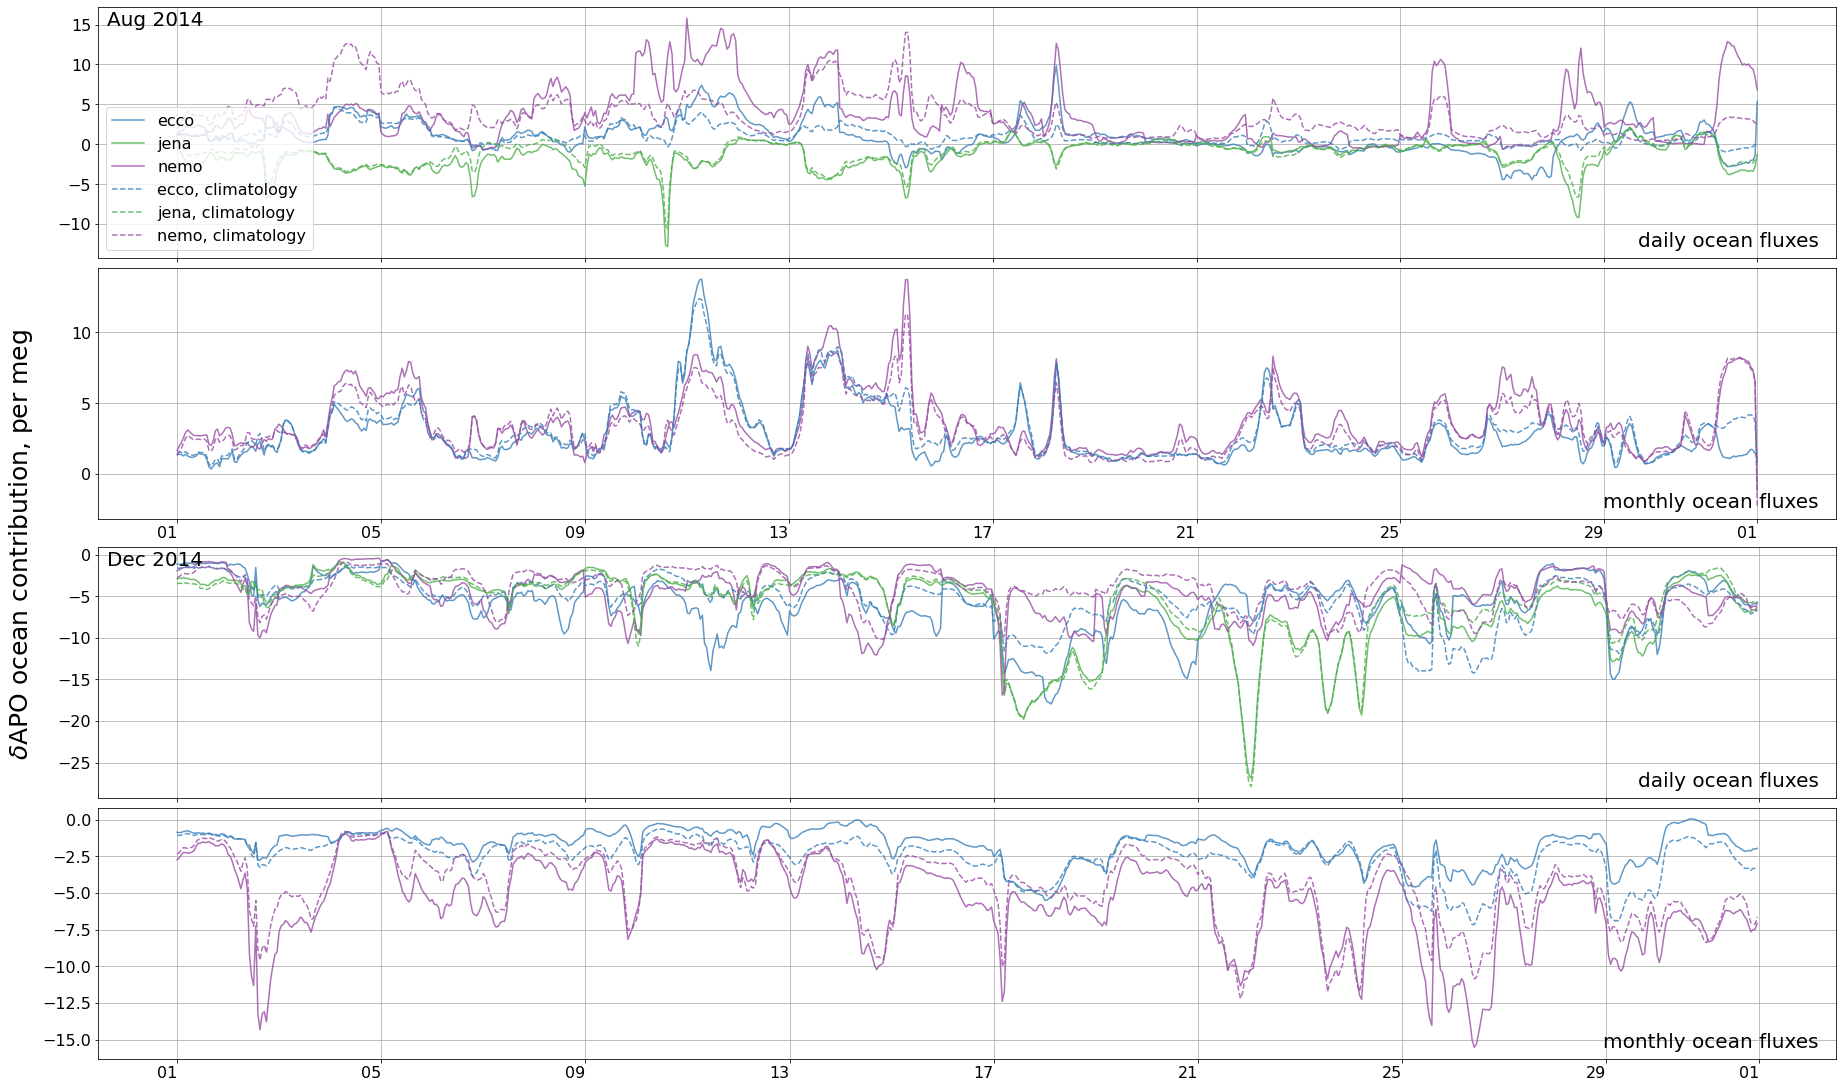

In [14]:
# labels = [{res: {spec: spec.split('_')[1] for spec in mf_res.keys()} for res, mf_res in mf_yr[months[0]].items()},
#           {res: {spec: f"{spec.split('_')[1]}, climatology" for spec in mf_res.keys()} for res, mf_res in mf_clim[months[0]].items()}]

fig, axes = plt.subplots(nrows=2*len(months), ncols=1, figsize=(25, 7.5*len(months)), constrained_layout=True)

for cc, (d_type, apo) in enumerate(apo_split.items()):
   for mm, (month, apo_month) in enumerate(apo.items()):
       labels = {res: {inv: inv if d_type=='yr' else f"{inv}, climatology" for inv in apo_res.keys()}
                 for res, apo_res in apo_month.items()}
       plots = [[ts.plot(ax=axes[rr+2*mm], label=labels[res][inv], color=plot_info.colors[inv], ls=ls[d_type], alpha=0.8)
                for inv, ts in ts_res.items()] for rr, (res, ts_res) in enumerate(apo_month.items())]

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       text = [axes[2*mm].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[2*mm].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]
            
legend = axes[0].legend(loc='lower left', fontsize=16)
xlab = [ax.set_xlabel('') for ax in axes]
ylab = [ax.set_ylabel('') for ax in axes]
grid = [ax.grid() for ax in axes]
ticks = [ax.tick_params(labelsize=16) for ax in axes]
[axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes))[0%2::2]]]
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO ocean contribution, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
res_labels = [axes[rr].text(0.99, 0.03, f'{res} ocean fluxes', fontsize=20, va='bottom', ha='right', transform=axes[rr].transAxes)
              for rr, res in enumerate(list(resolution.values())*2)]

date_str = '-'.join([f'{year}{str(month).zfill(2)}'for month in months])
spec_str = 'all' if len(species)==3 else '-'.join(species)
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Ocean',
                        f'{site}_APO_ocean_timeseries_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)